In [31]:
import  os
from matplotlib import pyplot as plt
import numpy as np


import mindspore as ms
import mindspore.context as context
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.nn.metrics import Accuracy


from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor


context.set_context(mode=context.GRAPH_MODE, device_target='CPU')


[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.131.000 [mindspore\context.py:1334] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


In [32]:
DATA_DIR_TRAIN = r"C:\Users\gobotinjr1\Downloads\MNIST\MNIST\train"
DATA_DIR_TEST = r"C:\Users\gobotinjr1\Downloads\MNIST\MNIST\test"
# Read data.
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
ds_test = ds.MnistDataset(DATA_DIR_TEST ) 
# Display the dataset features.
print('Data volume of the training dataset:',ds_train.get_dataset_size())
print('Data volume of the test dataset:',ds_test.get_dataset_size())
image=ds_train.create_dict_iterator().__next__()
print('Image length/width/channels:',image['image'].shape)
print('Image label style:',image['label'])    # Total 10 label classes which are represented by numbers from 0 to 9.


Data volume of the training dataset: 60000
Data volume of the test dataset: 10000
Image length/width/channels: (28, 28, 1)
Image label style: 7


In [33]:
def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    # Define the resizing, normalization, and channel conversion of the map operation.
    resize_op = CV.Resize(resize)
    rescale_op = CV.Rescale(rescale,shift)
    hwc2chw_op = CV.HWC2CHW()
    # Perform the map operation on the dataset.
    ds = ds.map(input_columns="image", operations=[rescale_op,resize_op, hwc2chw_op])
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    # Set the shuffle parameter and batch size.
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds


[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.243.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.243.000 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.244.000 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.244.000 [mindspore\dataset\core\validator_helpers.py:744] 'Typ

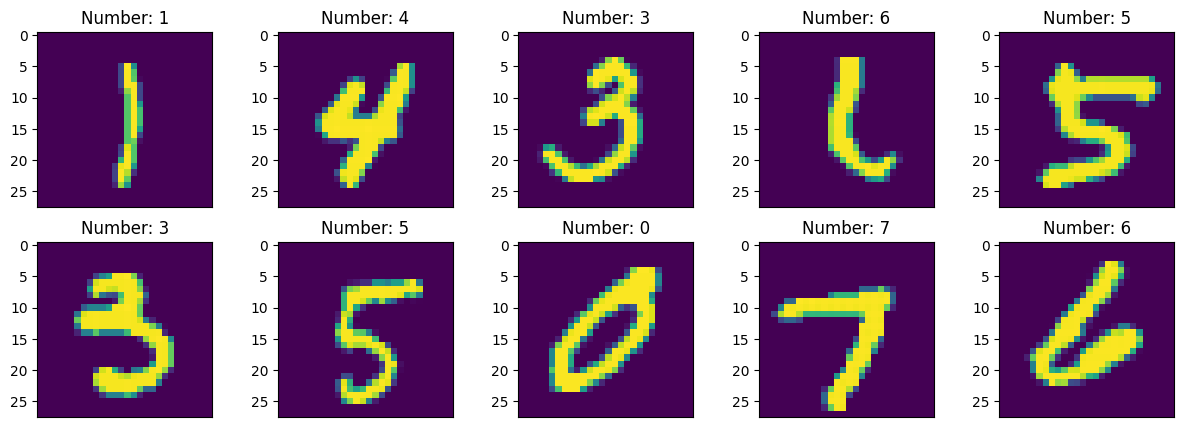

In [34]:
# Display the first 10 images and the labels, and check whether the images are correctly labeled.
ds = create_dataset(training=False)
data = ds.create_dict_iterator().__next__()
images = data['image'].asnumpy()
labels = data['label'].asnumpy()
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(np.squeeze(images[i]))
    plt.title('Number: %s' % labels[i])
    plt.xticks([])
plt.show()


In [35]:
# Create a model. The model consists of three fully connected layers. The final output layer uses softmax for classification (10 classes consisting of numbers 0 to 9.)
class ForwardNN(nn.Cell):      
    def __init__(self):
        super(ForwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(784, 512, activation='relu')  
        self.fc2 = nn.Dense(512, 128, activation='relu')
        self.fc3 = nn.Dense(128, 10, activation=None)
       
    
    def construct(self, input_x):
        output = self.flatten(input_x)
        output = self.fc1(output)
        output = self.fc2(output) 
        output = self.fc3(output)
        return output 


In [36]:
# Create a network, loss function, validation metric, and optimizer, and set related hyperparameters.
lr = 0.0001
num_epoch = 10
momentum = 0.9


net = ForwardNN()
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
metrics={"Accuracy": Accuracy()}
opt = nn.Adam(net.trainable_params(), lr) 


In [37]:
# Define custom callback to collect loss and accuracy per epoch
from mindspore.train.callback import Callback

class MetricsCollector(Callback):
    """Custom callback to collect loss and accuracy during training"""
    def __init__(self, eval_dataset, model_ref):
        self.eval_dataset = eval_dataset
        self.model_ref = model_ref
        self.train_loss_list = []
        self.eval_accuracy_list = []
        self.epoch_list = []
        self.step_loss_list = []
        self.step_count = 0
        self.epoch_loss = 0
        self.epoch_steps = 0
        
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs
        if isinstance(loss, (tuple, list)):
            loss = loss[0]
        if hasattr(loss, 'asnumpy'):
            loss = float(loss.asnumpy())
        elif hasattr(loss, 'item'):
            loss = float(loss.item())
        else:
            loss = float(loss)
        self.step_loss_list.append(loss)
        self.step_count += 1
        self.epoch_loss += loss
        self.epoch_steps += 1
        
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        epoch_num = cb_params.cur_epoch_num
        self.epoch_list.append(epoch_num)
        # Calculate average loss for epoch
        avg_loss = self.epoch_loss / self.epoch_steps if self.epoch_steps > 0 else 0
        self.train_loss_list.append(avg_loss)
        # Evaluate accuracy on validation dataset
        eval_metrics = self.model_ref.eval(self.eval_dataset)
        accuracy = eval_metrics.get('Accuracy', 0.0)
        self.eval_accuracy_list.append(accuracy)
        print(f"Epoch {epoch_num}: Loss = {avg_loss:.6f}, Validation Accuracy = {accuracy:.4f}")
        # Reset for next epoch
        self.epoch_loss = 0
        self.epoch_steps = 0

In [38]:
# Build a model and prepare for training with metrics collection
model = Model(net, loss, opt, metrics)
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck)
# Generate a dataset.
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)

# Create metrics collector callback
metrics_collector = MetricsCollector(ds_eval, model)

# Train the model.
loss_cb = LossMonitor(per_print_times=1875)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
print("============== Starting Training ==============")
model.train(num_epoch, ds_train, callbacks=[ckpoint_cb, loss_cb, time_cb, metrics_collector], dataset_sink_mode=False)

[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.544.000 [mindspore\dataset\core\validator_helpers.py:744] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.544.000 [mindspore\dataset\core\validator_helpers.py:744] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.545.000 [mindspore\dataset\core\validator_helpers.py:744] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(11096:15536,MainProcess):2026-01-21-08:30:39.545.000 [mindspore\dataset\core\validator_helpers.py:744] 'Typ

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.20693445205688477
Train epoch time: 2505.427 ms, per step time: 1.336 ms
Epoch 1: Loss = 0.485710, Validation Accuracy = 0.9268
epoch: 2 step: 1875, loss is 0.19096499681472778
Train epoch time: 2913.984 ms, per step time: 1.554 ms
Epoch 2: Loss = 0.223753, Validation Accuracy = 0.9440
epoch: 3 step: 1875, loss is 0.12018648535013199
Train epoch time: 3121.337 ms, per step time: 1.665 ms
Epoch 3: Loss = 0.168486, Validation Accuracy = 0.9521
epoch: 4 step: 1875, loss is 0.16517077386379242
Train epoch time: 3172.534 ms, per step time: 1.692 ms
Epoch 4: Loss = 0.133533, Validation Accuracy = 0.9610
epoch: 5 step: 1875, loss is 0.025110501796007156
Train epoch time: 3238.269 ms, per step time: 1.727 ms
Epoch 5: Loss = 0.109149, Validation Accuracy = 0.9662
epoch: 6 step: 1875, loss is 0.120867058634758
Train epoch time: 3296.179 ms, per step time: 1.758 ms
Epoch 6: Loss = 0.089499, Validation Accuracy = 0.9713

In [39]:
# Use the test set to validate the model and print the overall accuracy.
metrics=model.eval(ds_eval)
print(metrics)

{'Accuracy': 0.9783653846153846}


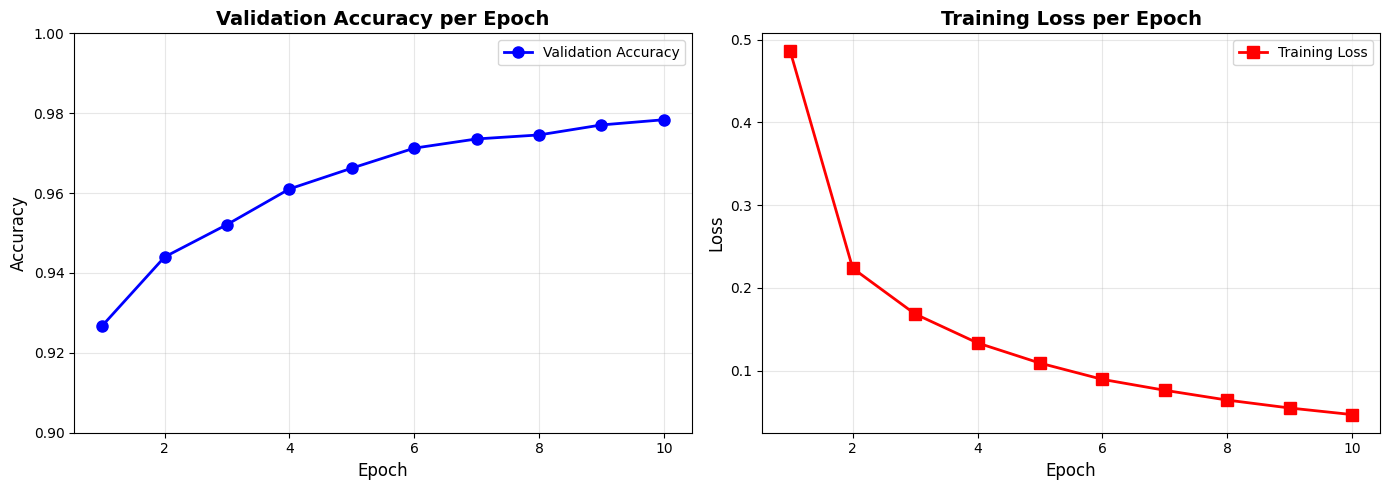


TRAINING SUMMARY
Best Validation Accuracy: 0.9784
Final Validation Accuracy: 0.9784
Final Training Loss: 0.046943


In [40]:
# Plot training curves using collected metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot validation accuracy per epoch
if metrics_collector.epoch_list and metrics_collector.eval_accuracy_list:
    ax1.plot(metrics_collector.epoch_list, metrics_collector.eval_accuracy_list, 
             marker='o', linestyle='-', linewidth=2, markersize=8, color='blue', label='Validation Accuracy')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title('Validation Accuracy per Epoch', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_ylim([0.9, 1.0])
else:
    ax1.text(0.5, 0.5, 'No accuracy data collected', ha='center', va='center', fontsize=12)
    ax1.set_title('Validation Accuracy per Epoch', fontsize=14, fontweight='bold')

# Plot training loss per epoch
if metrics_collector.epoch_list and metrics_collector.train_loss_list:
    ax2.plot(metrics_collector.epoch_list, metrics_collector.train_loss_list, 
             marker='s', linestyle='-', linewidth=2, markersize=8, color='red', label='Training Loss')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No loss data collected', ha='center', va='center', fontsize=12)
    ax2.set_title('Training Loss per Epoch', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
if metrics_collector.eval_accuracy_list:
    print(f"Best Validation Accuracy: {max(metrics_collector.eval_accuracy_list):.4f}")
    print(f"Final Validation Accuracy: {metrics_collector.eval_accuracy_list[-1]:.4f}")
if metrics_collector.train_loss_list:
    print(f"Final Training Loss: {metrics_collector.train_loss_list[-1]:.6f}")

In [41]:
# Custom callback to track loss and accuracy per epoch for visualization
from mindspore.train.callback import Callback

class LossAccuracyLogger(Callback):
    def __init__(self):
        self.epoch_loss_list = []
        self.epoch_accuracy_list = []
        self.epoch_list = []
        
    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        epoch_num = cb_params.cur_epoch_num
        self.epoch_list.append(epoch_num)
        # Evaluate on validation set to get accuracy
        cur_model = cb_params.train_network
        print(f"Epoch {epoch_num} completed")
        
loss_acc_logger = LossAccuracyLogger()
